In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods, models
from benchmark.simple_sensitivity import simple_sensitivity
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
# General parameters
dataset_name = "MNIST"
batch_size = 64
n_batches = 16
normalize_attrs = False
use_logits = True
data_root = "../data"

In [4]:
# CIFAR10 parameters
if dataset_name == "CIFAR10":
    mask_range = list(range(1, 1000, 100))
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"), download=False, shuffle=False, version="cifar10")
    model = models.CifarResnet(version="resnet32", params_loc=path.join(data_root, "models/cifar10_resnet32.pth"), num_classes=10, output_logits=use_logits)
    model.eval()

In [5]:
# MNIST parameters
if dataset_name == "MNIST":
    mask_range = list(range(1, 128, 10))
    dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"), download=False, shuffle=False)
    model = models.MNISTCNN(params_loc=path.join(data_root, "models/MNIST_cnn.pth"), output_logits=use_logits)
    model.eval()

In [6]:
attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), normalize=normalize_attrs),
    "Gradient": methods.Gradient(model, normalize=normalize_attrs),
    "InputXGradient": methods.InputXGradient(model, normalize=normalize_attrs),
    "IntegratedGradients": methods.IntegratedGradients(model, normalize=normalize_attrs),
    "GuidedBackprop": methods.GuidedBackprop(model, normalize=normalize_attrs),
    "Deconvolution": methods.Deconvolution(model, normalize=normalize_attrs),
    "Random": methods.Random(normalize=normalize_attrs)
}

In [8]:
result = simple_sensitivity(itertools.islice(dataset.get_test_data(), n_batches), model, attribution_methods, mask_range, dataset.mask_value)

/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [9]:
result_df = pd.DataFrame.from_dict(
    {m_name: pd.DataFrame(data=result[m_name]).stack() for m_name in attribution_methods}
).stack().reset_index()
result_df.columns = ["sample", "mask", "method", "difference"]
result_df["mask"] = np.array(mask_range)[result_df["mask"]]

In [10]:
result_df

,sample,mask,method,difference
0,0,1,Gradient,56.708328
1,0,1,InputXGradient,56.708328
2,0,1,IntegratedGradients,56.708328
3,0,1,GuidedBackprop,56.708328
4,0,1,Deconvolution,56.708328
...,...,...,...,...
79867,1023,121,InputXGradient,-8.518167
79868,1023,121,IntegratedGradients,-3.256919
79869,1023,121,GuidedBackprop,-3.187527
79870,1023,121,Deconvolution,-3.187527


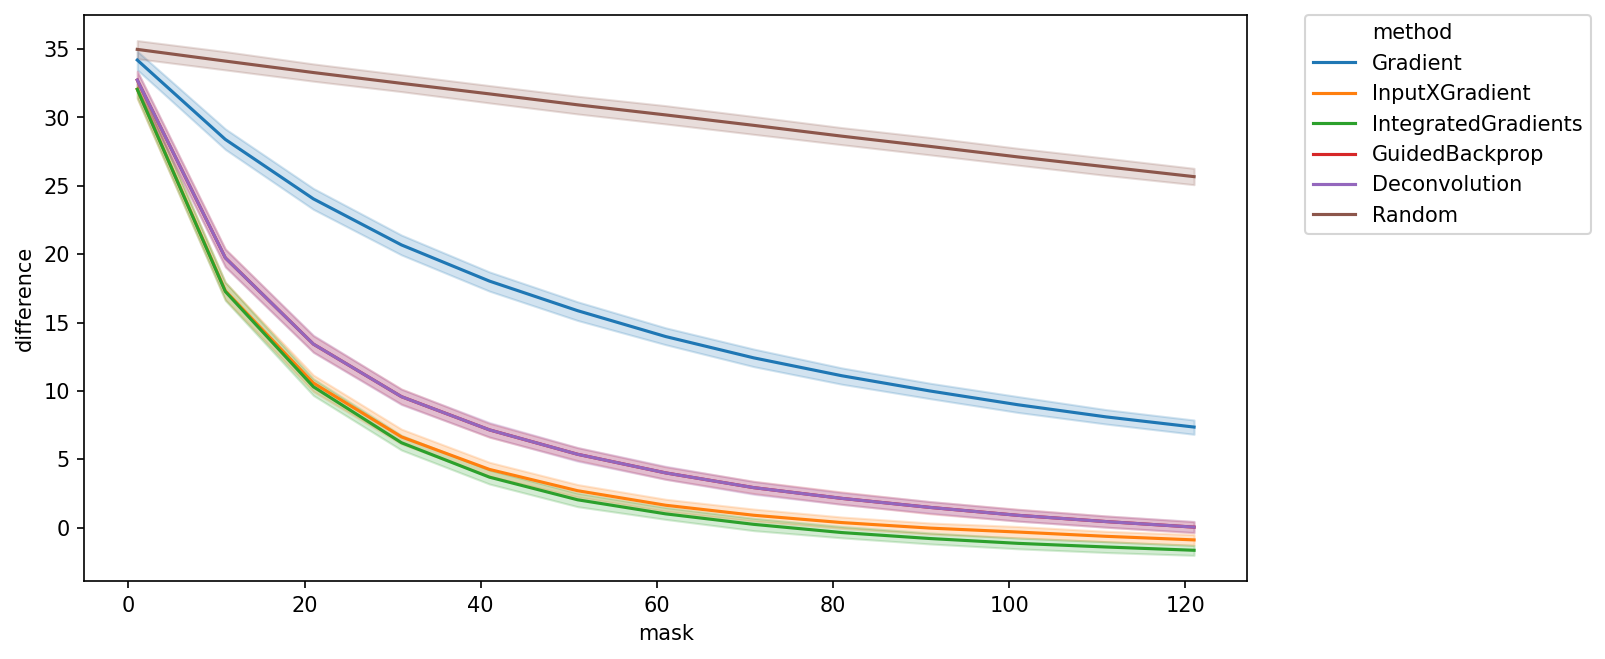

In [11]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="mask", y="difference", hue="method", data=result_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)